In [15]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [16]:
# remotes::install_github("glmmTMB/glmmTMB", subdir = "glmmTMB")


In [17]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR.csv" # nolint

regression_df <- read.csv(local_input_path)
print(regression_df)


           date       regiao mental_health_visits total_atd periodo
1    2016-01-01          sul                38152   1491781       1
2    2016-02-01          sul                51908   2019943       2
3    2016-03-01          sul                62072   2652117       3
4    2016-04-01          sul                52677   2126983       4
5    2016-05-01          sul                55141   2382835       5
6    2016-06-01          sul                63802   2681087       6
7    2016-07-01          sul                62187   2506770       7
8    2016-08-01          sul                72404   2991575       8
9    2016-09-01          sul                64658   2694636       9
10   2016-10-01          sul                56849   2345810      10
11   2016-11-01          sul                55079   2157356      11
12   2016-12-01          sul                44722   1701881      12
13   2017-01-01          sul                52788   2078724      13
14   2017-02-01          sul                5105

# Imports

In [18]:
# install.packages(c(
#    "lme4",
#     "performance",
#      "DHARMa",
#      "ggplot2",
#      "ggeffects",
#      "purrr",
#      "emmeans",
#      "performance",
#      "dplyr",
#      "patchwork",
#      "see",
#      "broom.mixed",
#      "dotwhisker",
#      "tidyr",
#      "stringr",
#      "glarma",
#      "brms",
#      "remotes",
#      "tibble"))

# install.packages(c("gamlss.add"))
# install.packages(c(
#    # "lubridate",
#    # "ggplot2",
#    # "purrr",
#    #"glmmTMB"
# ))
library(gamlss.add)
library(gamlss)
library(glarma)
library(dplyr)
library(MASS)
library(nlme)
library(purrr)
library(brms)
library(cmdstanr)
library(glmmTMB) # For NB GLMM with autocorrelation
# library(lme4) # Alternative for basic GLMM
# library(performance) # For model checks
# library(DHARMa) # For residual diagnostics
# library(ggplot2) # For plots
# library(ggeffects)
# library(purrr)
# library(emmeans)
# library(performance)

# library(patchwork)
# library(see)
# library(broom.mixed)
# library(dotwhisker)
# library(tidyr)
# library(stringr)
# library(glarma)
# library(brms)
# library(remotes)
# library(tibble)


In [19]:
options(repr.plot.width = 16, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown


# Model Defs

In [20]:
#' Fit GLMM with PQL estimation and AR(1) structure
#'
#' @param data Dataframe containing all variables
#' @param response_var Name of response variable (count data)
#' @param fixed_effects Vector of fixed effect variable names
#' @param offset_var Name of offset variable (should be log-transformed)
#' @param time_var Name of time variable for AR(1) structure
#' @param group_var Name of grouping variable (default intercept-only)
#' @param theta Starting value for negative binomial theta (NULL for estimation)
#'
#' @return Fitted model object
#' @export
#'
#' @examples
#' model <- fit_glmm_ar1(
#'   data = my_data,
#'   response_var = "mental_health_visits",
#'   fixed_effects = c("periodo", "Pandemia_Step", "Pandemia_Trend"),
#'   offset_var = "log_total_visits",
#'   time_var = "month"
#' )
fit_glmm_ar1 <- function(data,
                         response_var,
                         fixed_effects,
                         offset_var = NULL,
                         time_var,
                         group_var = NULL,
                         theta = 1) {
  # Load required packages
  require(nlme)
  require(MASS)

  # Create formula components
  fixed_part <- paste(
    response_var, "~",
    paste(fixed_effects, collapse = " + ")
  )

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Handle grouping structure
  if (is.null(group_var)) {
    data$..group.. <- factor(1) # Intercept-only random effect
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Fit model
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta), # quasipoisson(),#poisson(),#
    correlation = corAR1(form = cor_formula),
    data = data,
    verbose = FALSE
  )


  # Add model components to object for easier reference
  model$call$fixed <- fixed_part
  model$call$random <- random_formula
  model$call$correlation <- cor_formula

  return(model)
}


In [21]:
fit_glmm_arma <- function(data,
                          response_var,
                          fixed_effects,
                          offset_var = NULL,
                          time_var,
                          group_var = NULL,
                          theta = 1,
                          ar_order = 1, # Ordem AR(p)
                          ma_order = 0) { # Ordem MA(q)

  require(nlme)
  require(MASS)
  require(dplyr)

  # Criar fórmula fixa
  fixed_part <- paste(response_var, "~", paste(fixed_effects, collapse = " + "))

  if (!is.null(offset_var)) {
    fixed_part <- paste(fixed_part, "+ offset(", offset_var, ")")
  }

  # Estrutura aleatória
  if (is.null(group_var)) {
    data$..group.. <- factor(1)
    random_formula <- ~ 1 | ..group..
    cor_formula <- as.formula(paste("~", time_var, "| ..group.."))
  } else {
    random_formula <- as.formula(paste("~ 1 |", group_var))
    cor_formula <- as.formula(paste("~", time_var, "|", group_var))
  }

  # Estrutura de correlação ARMA
  if (ar_order > 0 | ma_order > 0) {
    cor_struct <- corARMA(form = cor_formula, p = ar_order, q = ma_order)
  } else {
    cor_struct <- NULL
  }

  # Ajustar modelo
  model <- glmmPQL(
    fixed = as.formula(fixed_part),
    random = random_formula,
    family = negative.binomial(theta = theta),
    correlation = cor_struct,
    data = data,
    verbose = FALSE
  )

  return(model)
}


# Model Run

In [22]:
# Inicialize uma lista para guardar os modelos
models_list <- list()

# Loop para ajustar os modelos por região e armazenar na lista
for (reg in unique(regression_df$regiao)) {
  require(dplyr)
  cat("=============================================Rodando:", reg, "\n")
  reg_data <- regression_df %>% filter(regiao == reg)

  model <- fit_glmm_arma(
    data = reg_data,
    response_var = "mental_health_visits",
    fixed_effects = c(
      "periodo", "Pandemia_Step", "Pandemia_Trend",
      "PosPandemia_Step", "PosPandemia_Trend", "cos1_12", "sin1_12", "cos1_6", "sin1_6" # , "cos1", "sin1"
    ),
    offset_var = "offset",
    time_var = "periodo",
    ar_order = 1,
    ma_order = 1,
  )


  # Armazenar o modelo na lista com a chave sendo a região
  models_list[[reg]] <- model
  # print('-----R² condicional/marginal')
  # print(performance::r2(model))  # R² condicional/marginal
  # Imprimir o resumo do modelo para verificação
  print(summary(model))
}


=============================================Rodando: sul 
Linear mixed-effects model fit by maximum likelihood
  Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | ..group..
         (Intercept)   Residual
StdDev: 8.759069e-07 0.05190018

Correlation Structure: ARMA(1,1)
 Formula: ~periodo | ..group.. 
 Parameter estimate(s):
        Phi1       Theta1 
-0.003103003  0.439193391 
Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +      PosPandemia_Step + PosPandemia_Trend + cos1_12 + sin1_12 +      cos1_6 + sin1_6 + offset(offset) 
                      Value  Std.Error DF   t-value p-value
(Intercept)        3.180541 0.02022311 86 157.27259  0.0000
periodo            0.001817 0.00067250 86   2.70156  0.0083
Pandemia_Step      0.185563 0.03457077 86   5.36764  0.0000
Pandemia_Trend    -0.012949 0.00217680 86  -5.94869  0.0000
PosPandemia_Step  -0.107290 0.04684346 86 

# Diagnóstico

In [23]:
# GLMM TMB
if (!dir.exists("acf_plots")) dir.create("acf_plots")
if (!dir.exists("model_tests")) dir.create("model_tests")

sink(file = "model_tests/ljung_box_results.txt")

for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Resíduos de Pearson
  res <- residuals(model, type = "pearson")

  # Plot ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  acf(res, main = paste("ACF -", reg), lag.max = 36, ylim = c(-0.5, 1))
  pacf(res, main = paste("PACF -", reg), lag.max = 36, ylim = c(-0.5, 1))

  dev.off()

  # Teste Ljung-Box
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos de Pearson:\n\n")

  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  cat("Gráficos e testes gerados para:", reg, "\n")
}

sink()


In [24]:
# Criar pastas para salvar os resultados
if (!dir.exists("acf_plots")) {
  dir.create("acf_plots")
}
if (!dir.exists("model_tests")) {
  dir.create("model_tests")
}

# Arquivo para salvar os testes Ljung-Box
sink(file = "model_tests/ljung_box_results.txt")

# Loop através de cada modelo na lista
for (reg in names(models_list)) {
  model <- models_list[[reg]]

  # Extrair resíduos normalizados
  res <- residuals(model, type = "normalized")

  # Gráficos ACF/PACF
  png(
    filename = paste0("acf_plots/", reg, "_acf_pacf.png"),
    width = 10, height = 5, units = "in", res = 300
  )
  par(mfrow = c(1, 2))

  # Plot ACF
  acf(res,
    main = paste("ACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  # Plot PACF
  pacf(res,
    main = paste("PACF -", reg),
    lag.max = 36,
    ylim = c(-0.5, 1)
  )

  dev.off()

  # Teste Ljung-Box para diferentes lags
  cat("\n----------------------------------------\n")
  cat("Região:", reg, "\n")
  cat("Testes Ljung-Box para resíduos:\n\n")

  # Testar para lags específicos (1, 9, 12, 24, 25)
  for (lag in c(1, 9, 12, 24, 25)) {
    test <- Box.test(res, lag = lag, type = "Ljung-Box")
    cat(sprintf("Lag %2d: p-valor = %.4f", lag, test$p.value))

    # Adicionar asterisco para significância
    if (test$p.value < 0.05) {
      cat(" *")
      if (test$p.value < 0.01) cat("*")
      if (test$p.value < 0.001) cat("*")
    }
    cat("\n")
  }

  # Mostrar mensagem de progresso
  cat("Gráficos e testes gerados para:", reg, "\n")
}

# Fechar o arquivo de saída
sink()


# Plot

Plotando: sul 
Plotando: sudeste 


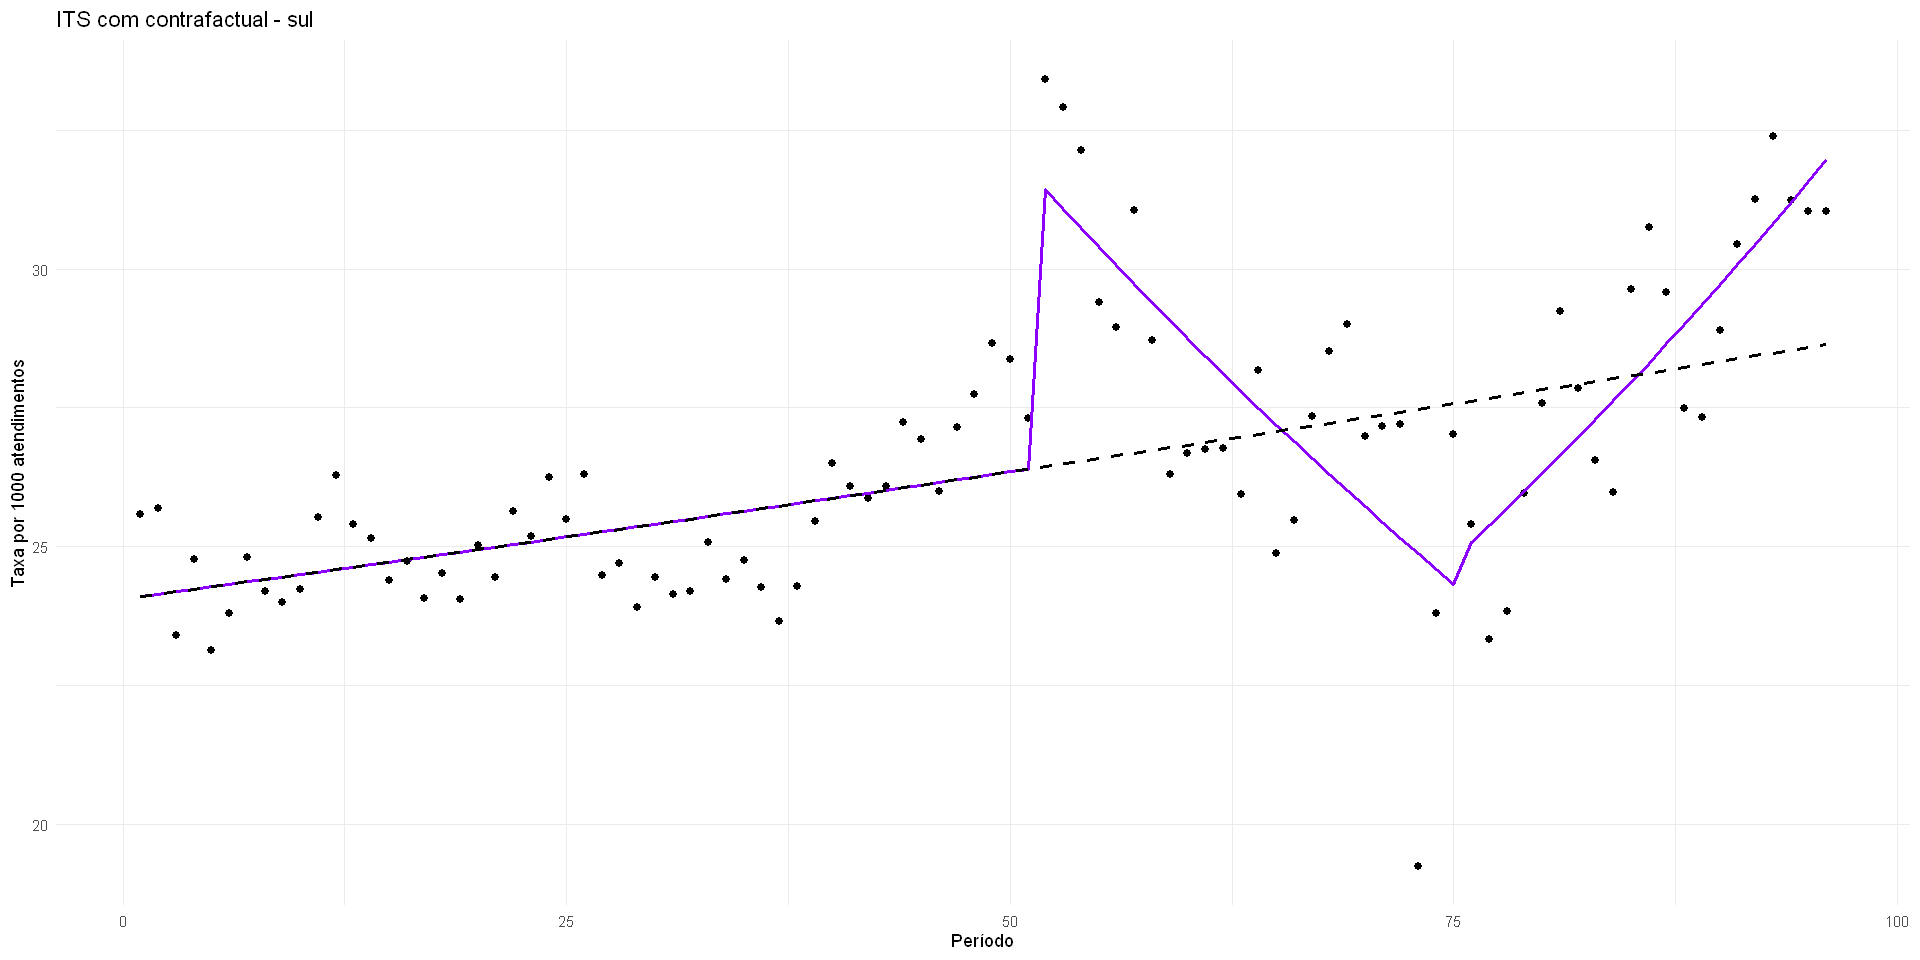

Plotando: norte 


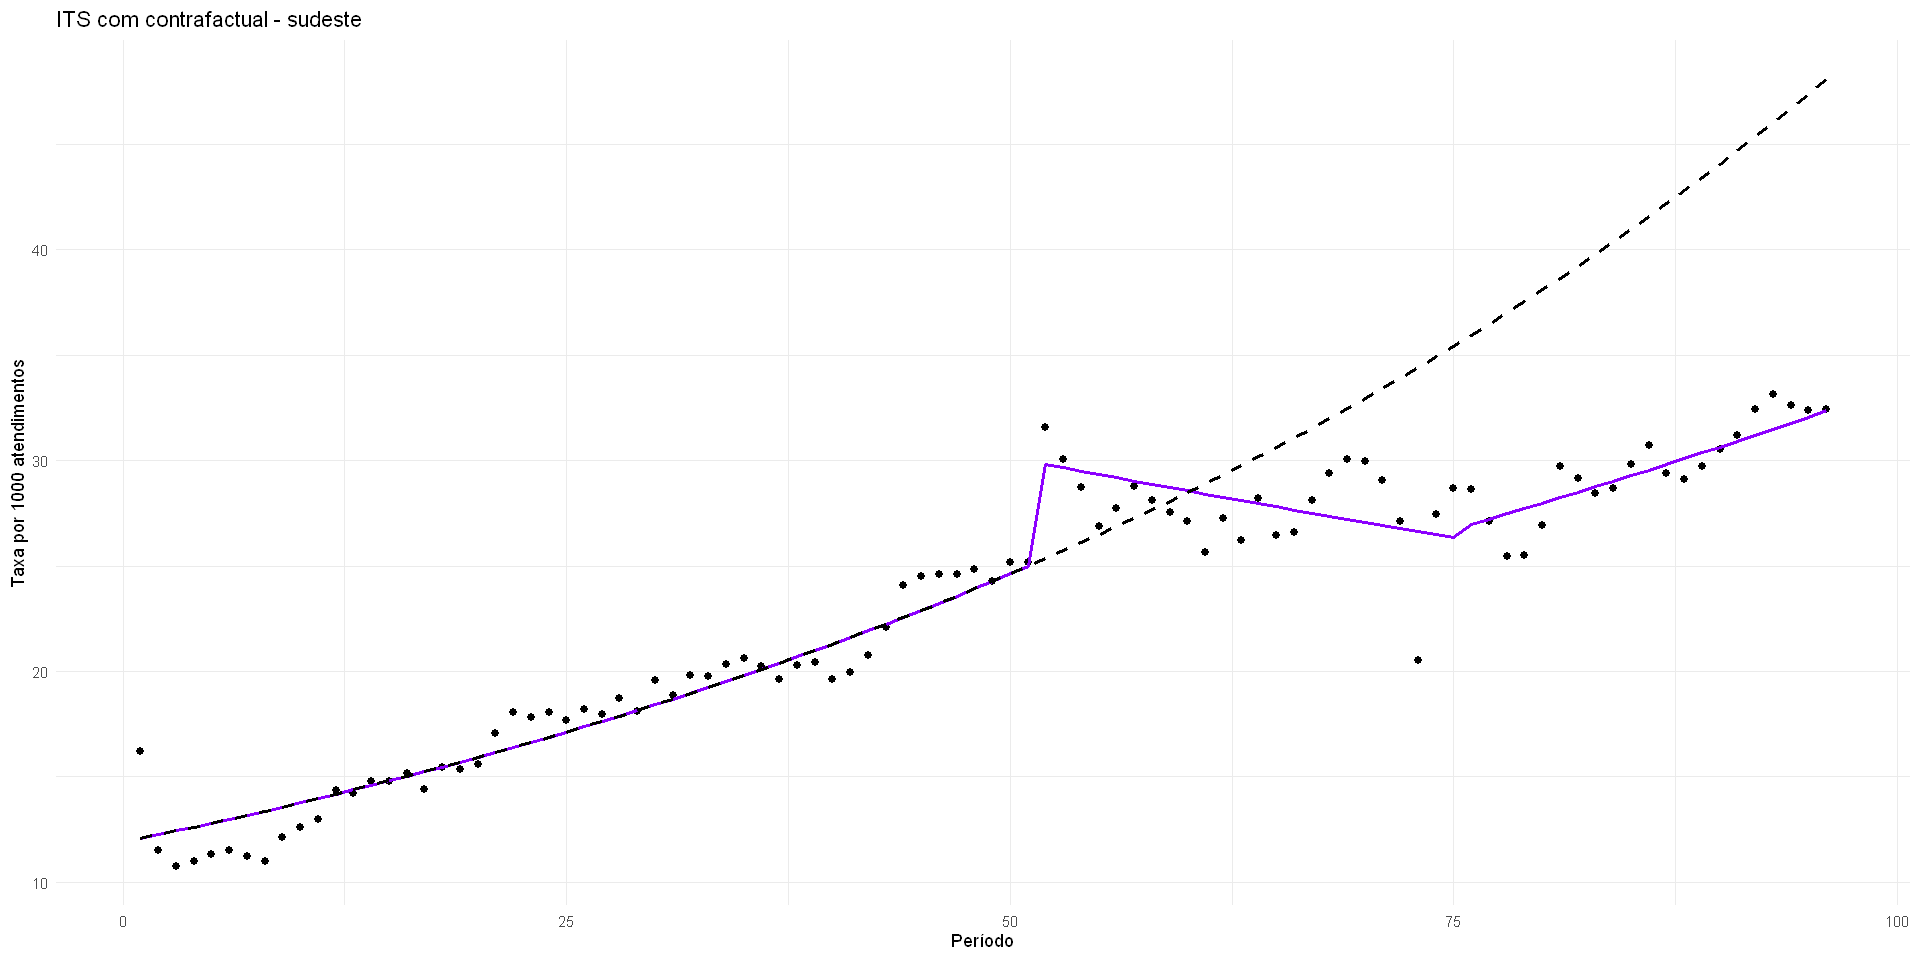

Plotando: nordeste 


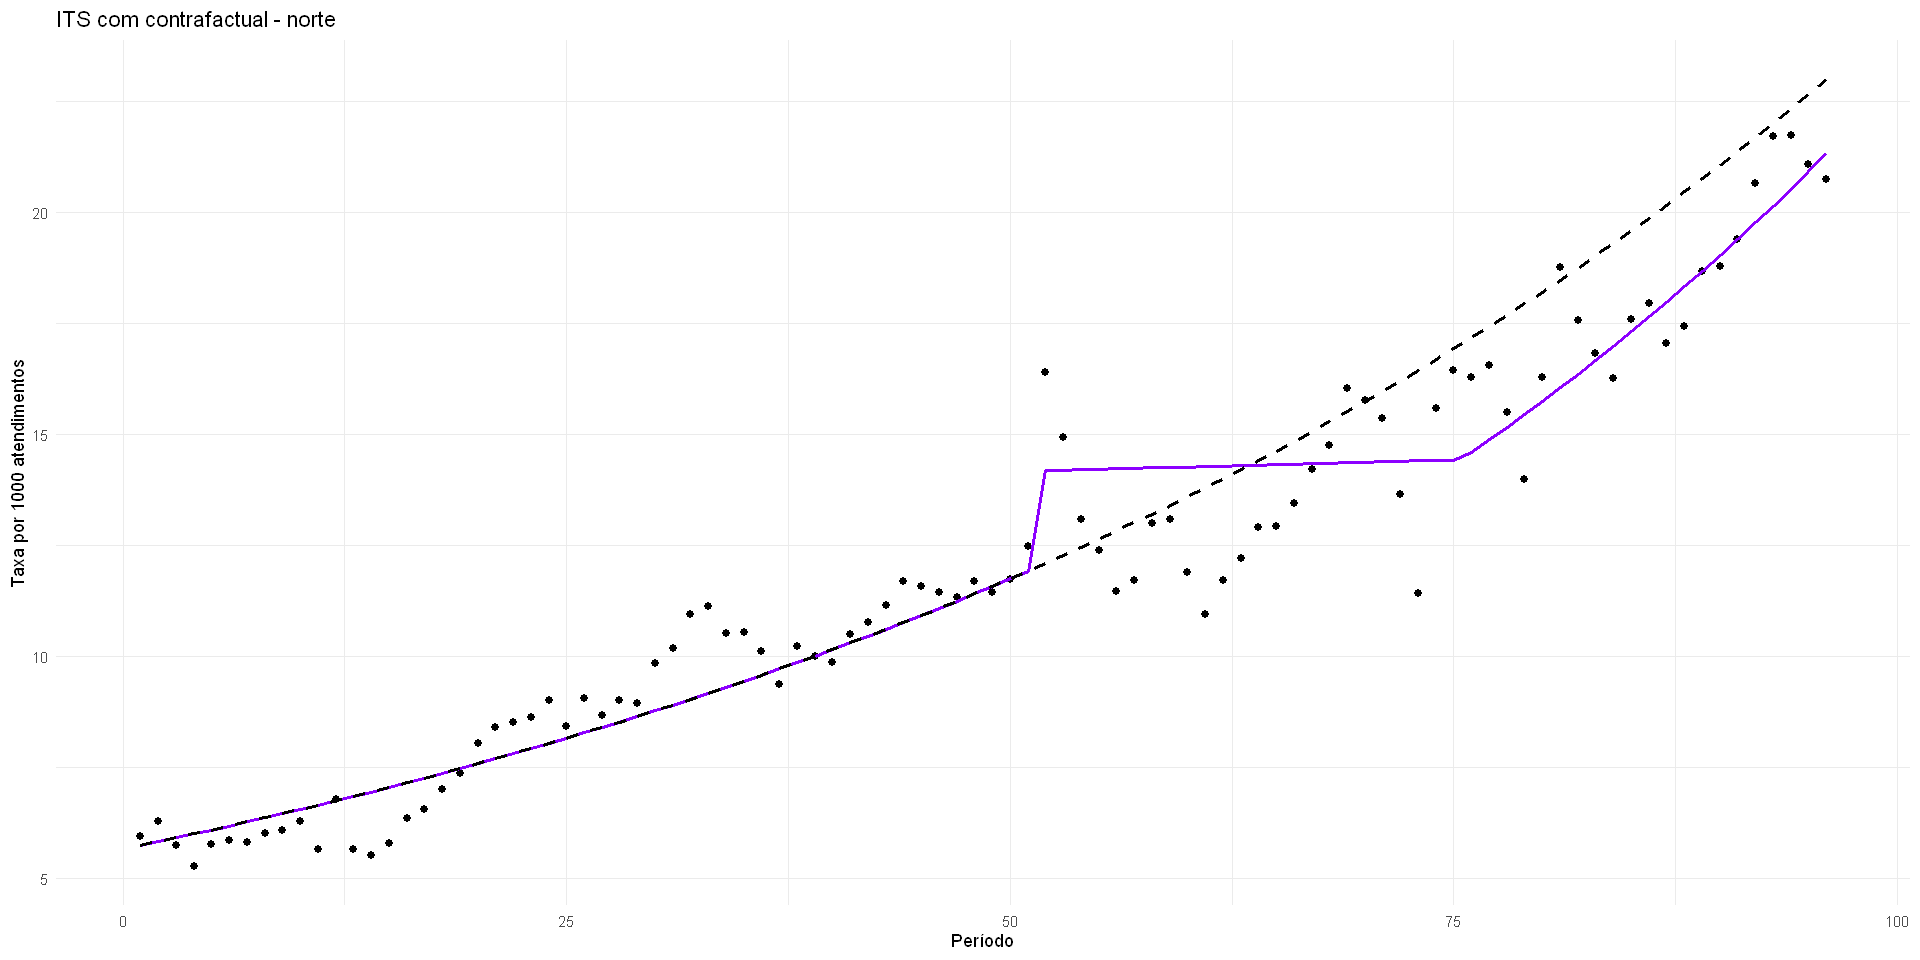

Plotando: centro_oeste 


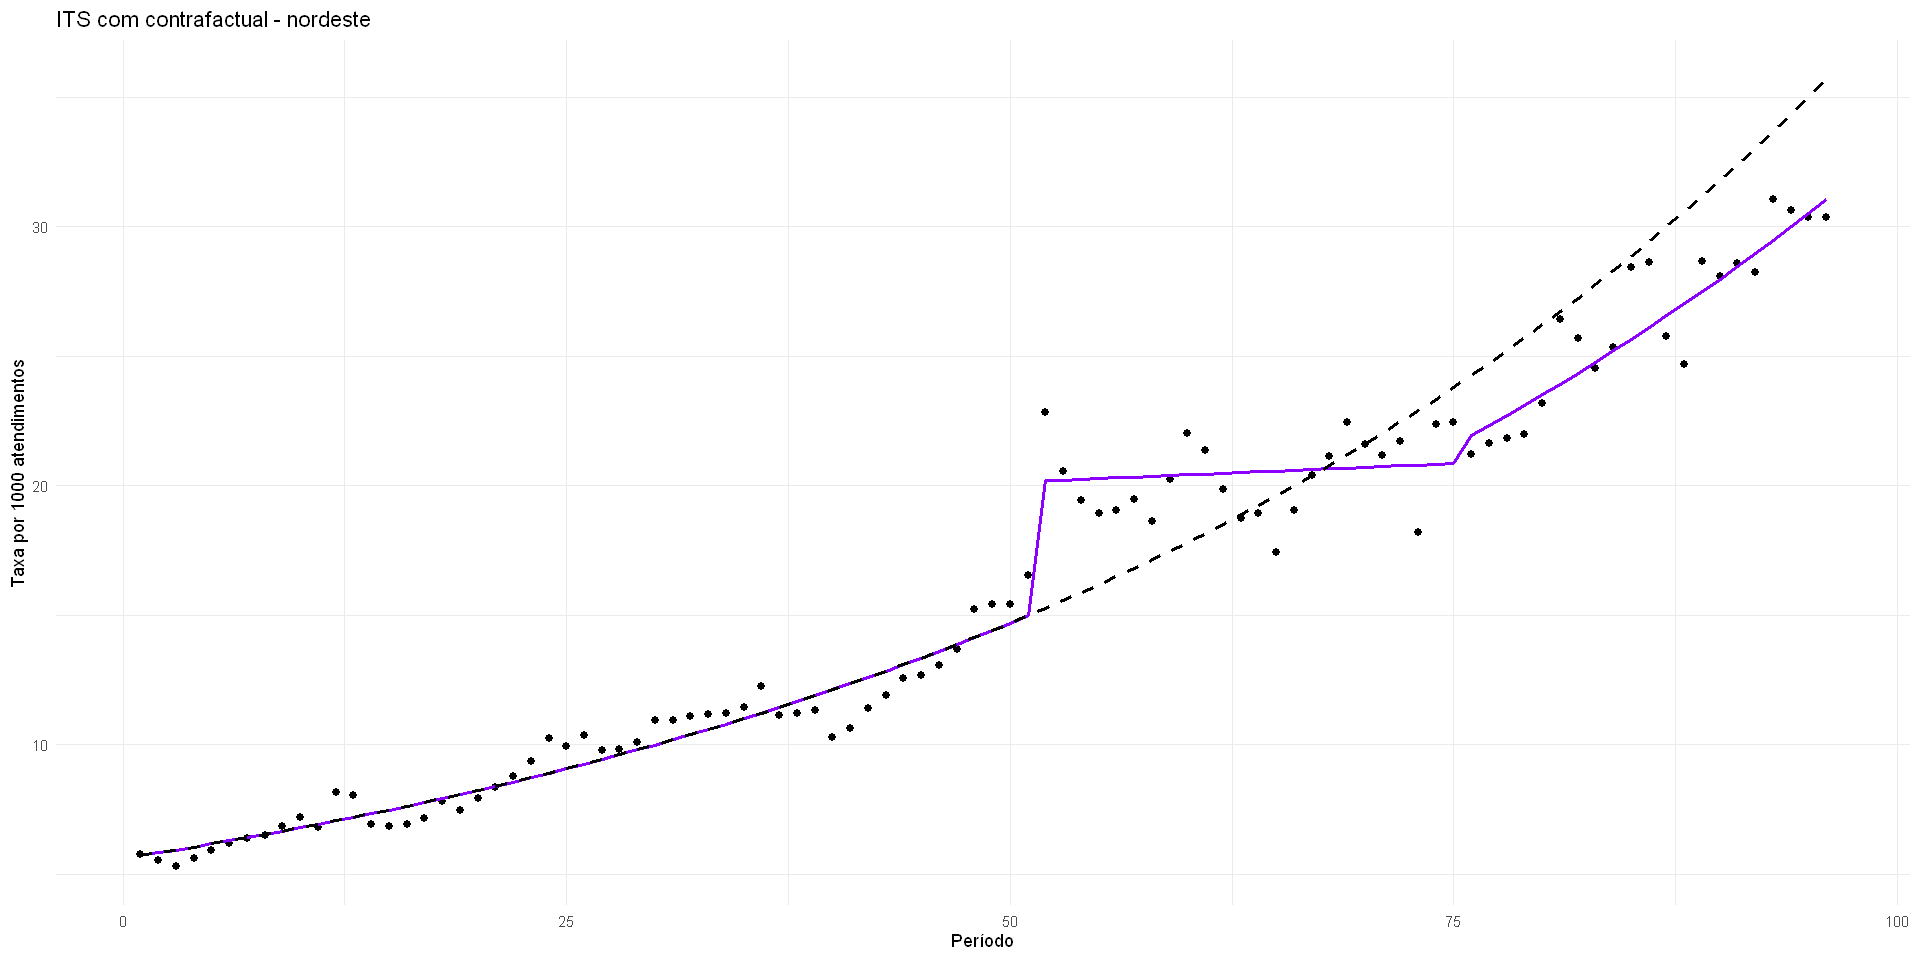

Plotando: F99_F99 


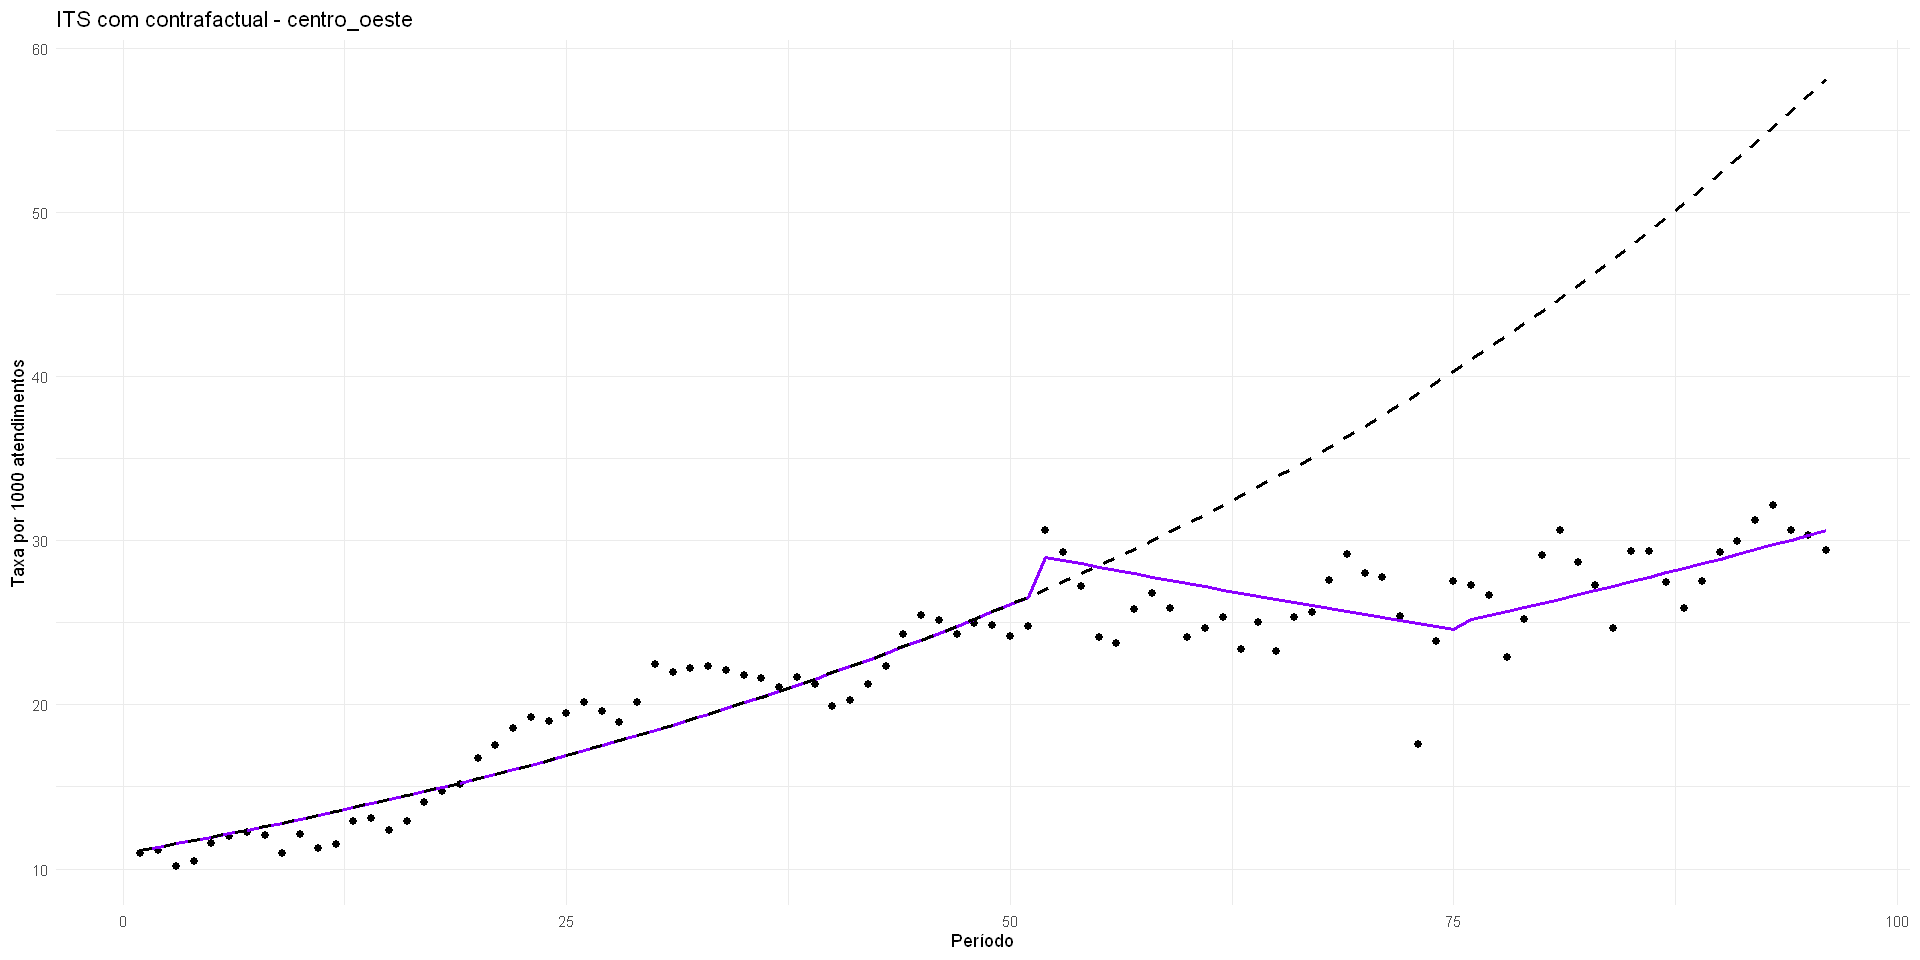

Plotando: F90_F98 


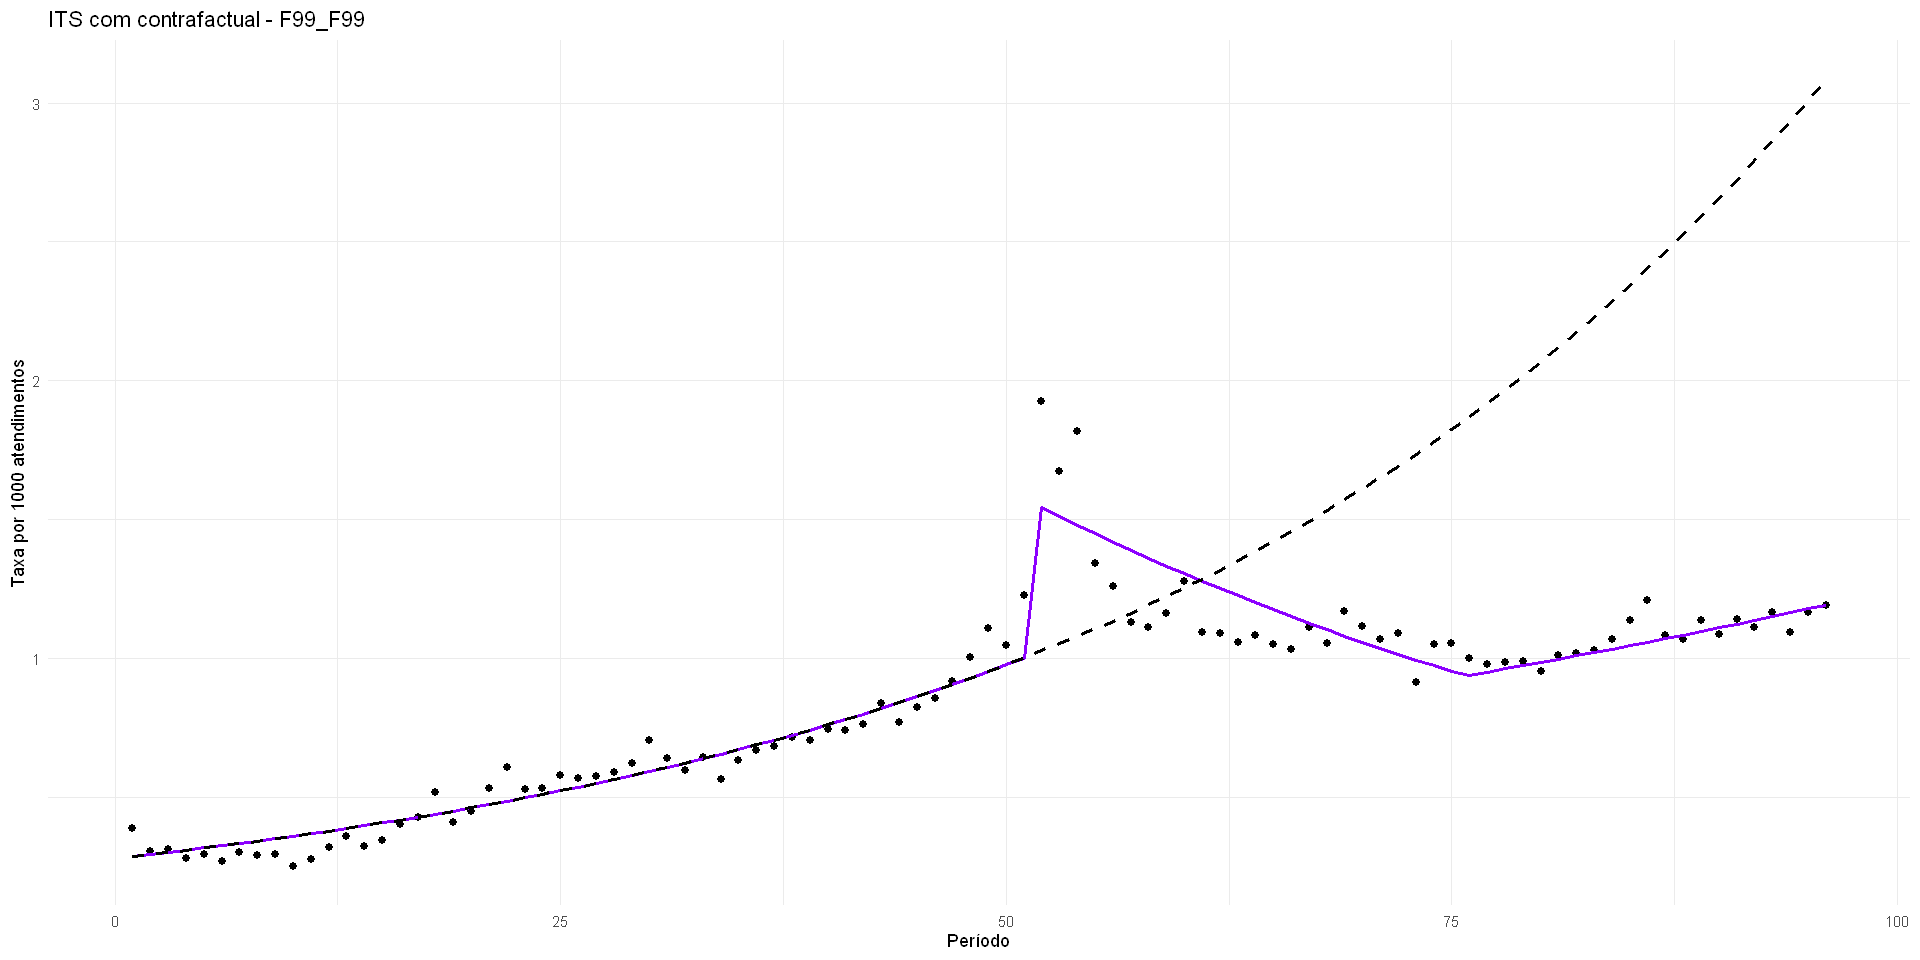

Plotando: F80_F89 


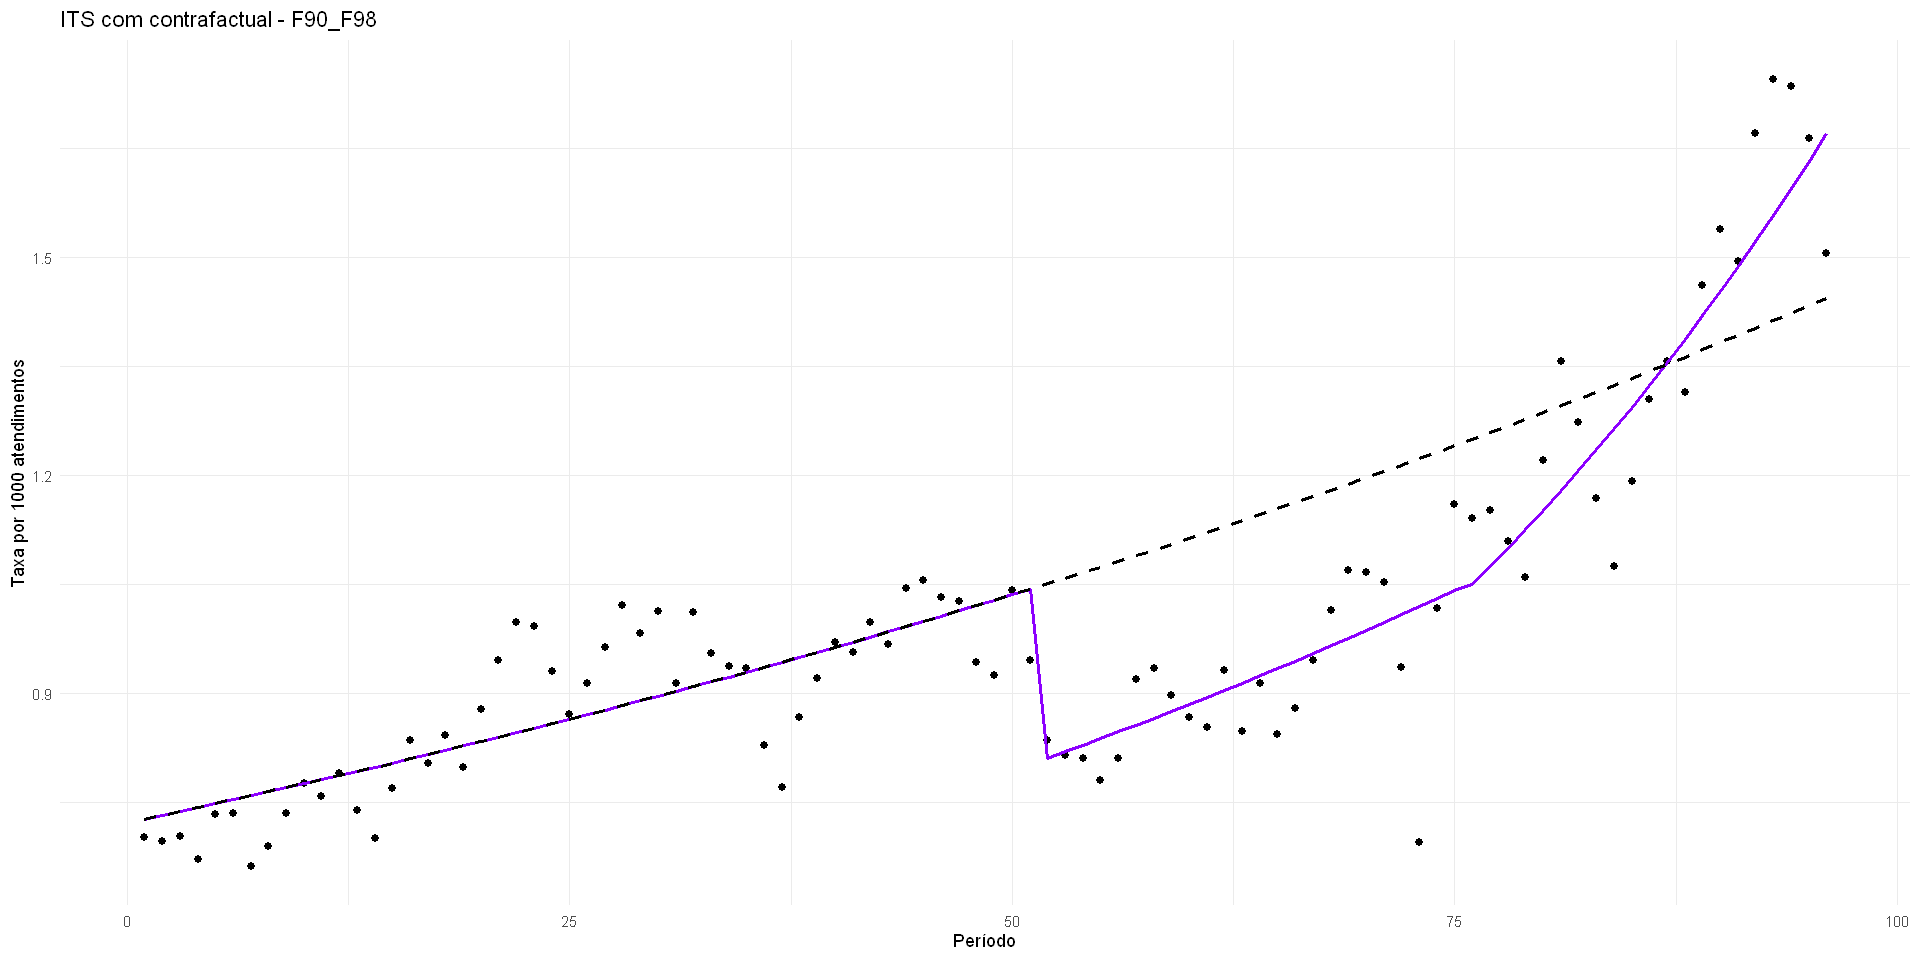

Plotando: F70_F79 


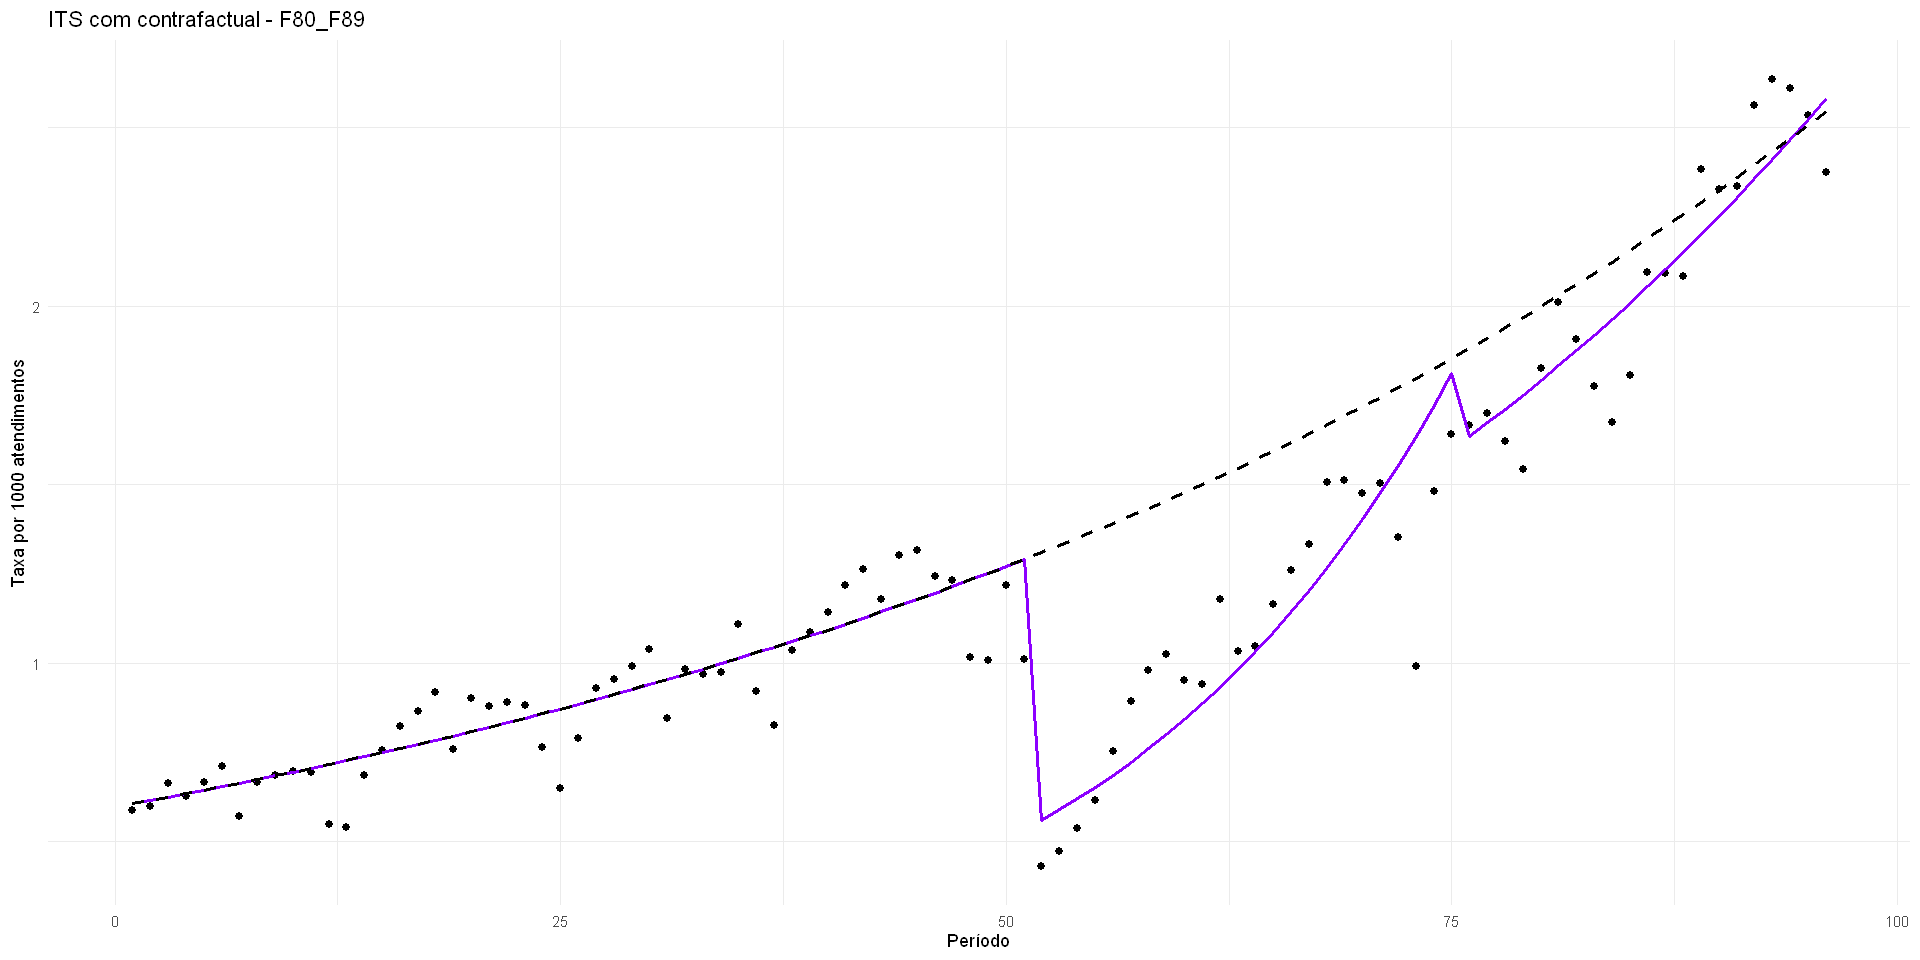

Plotando: F60_F69 


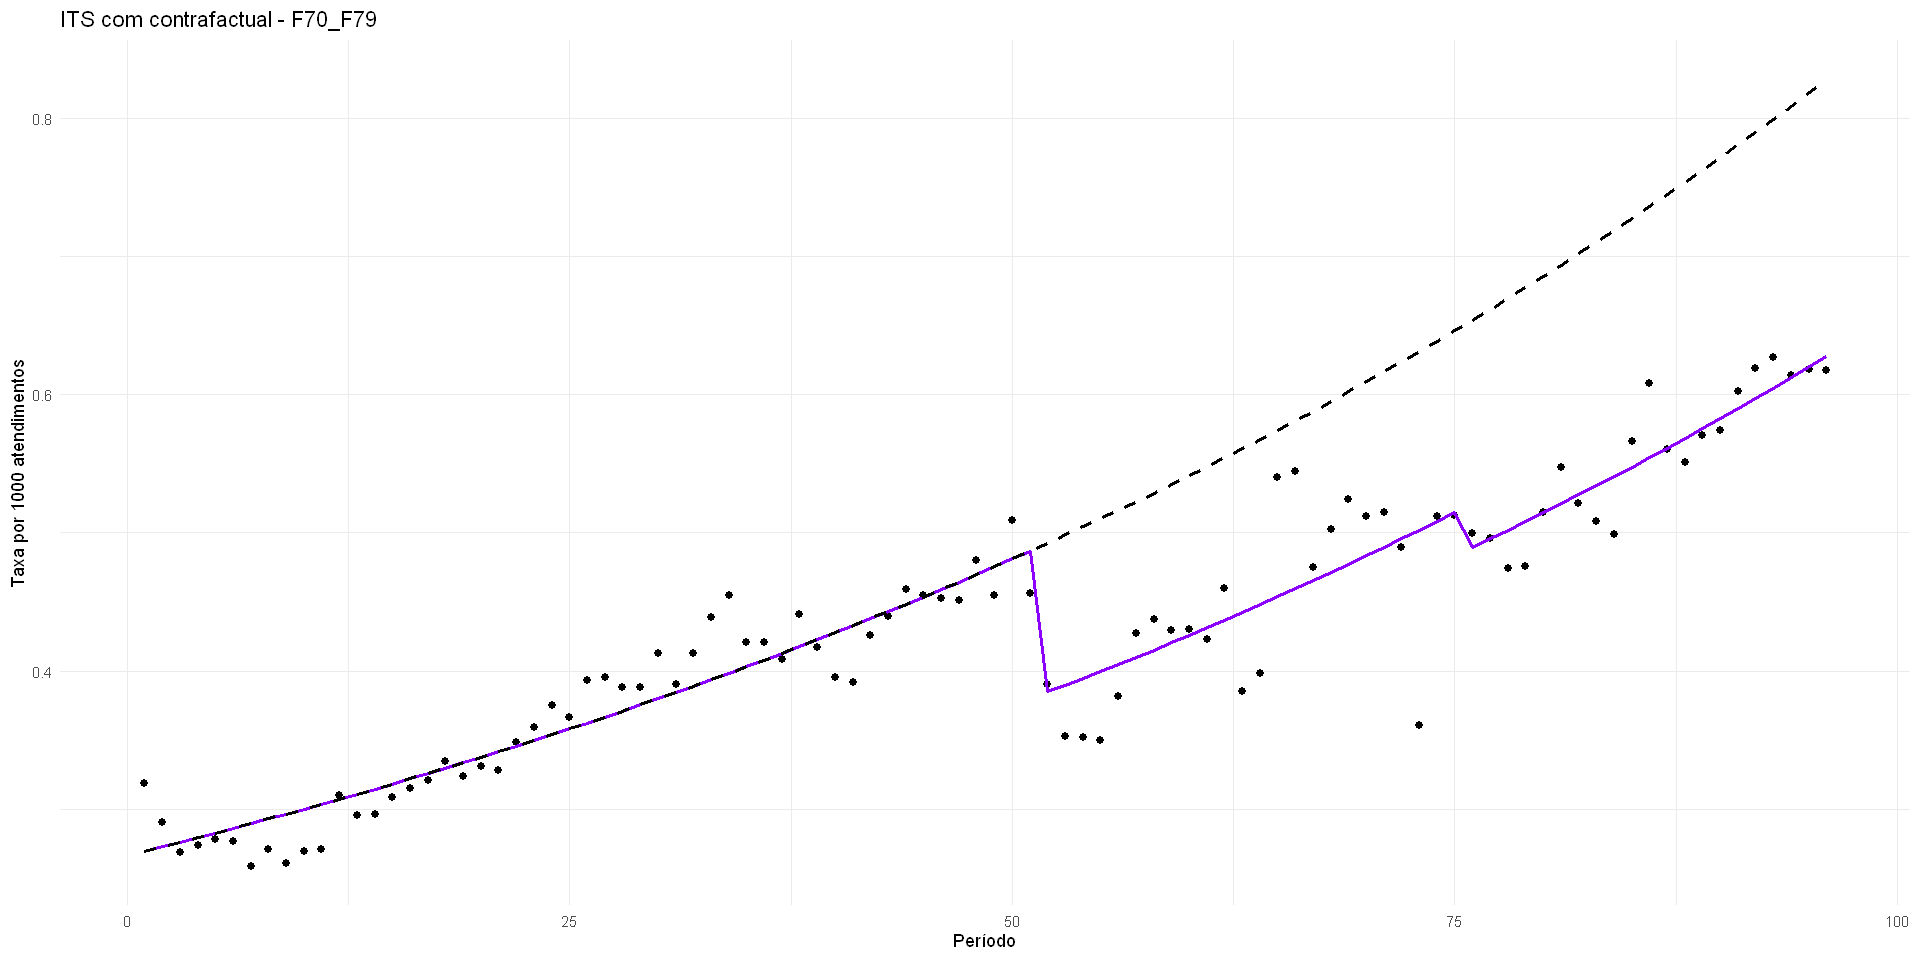

Plotando: F50_F59 


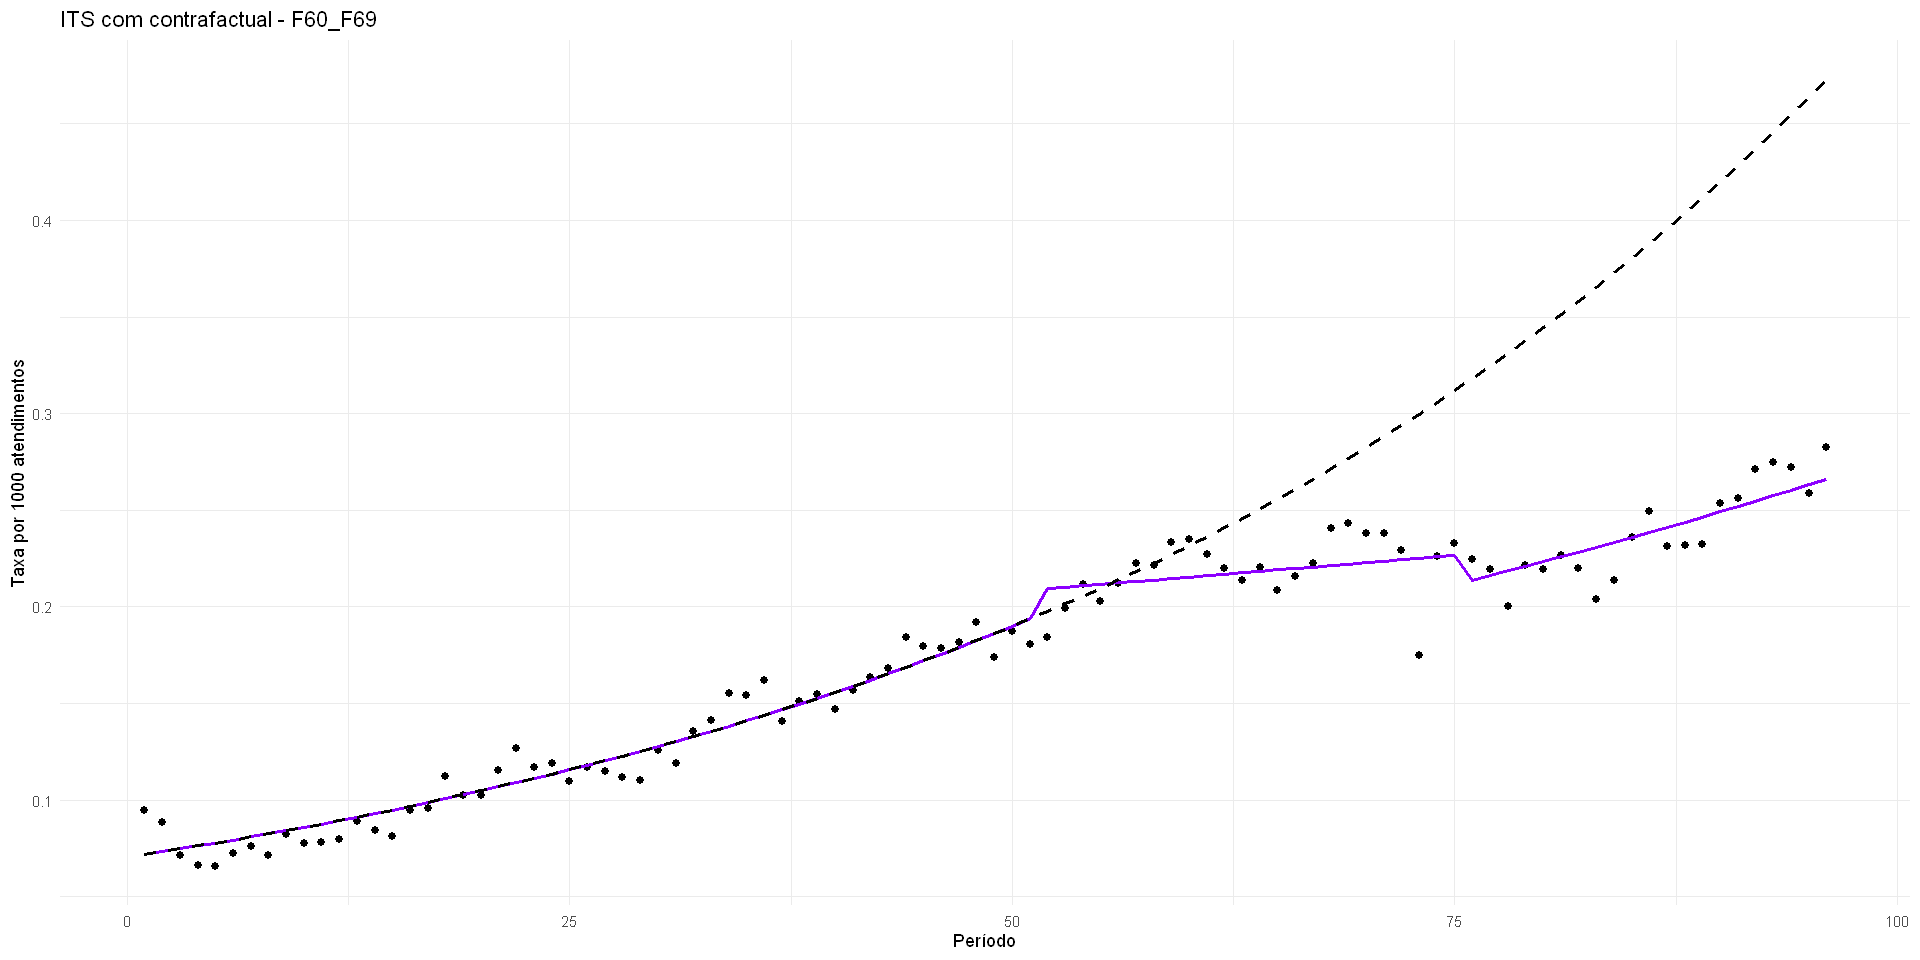

Plotando: F40_F48 


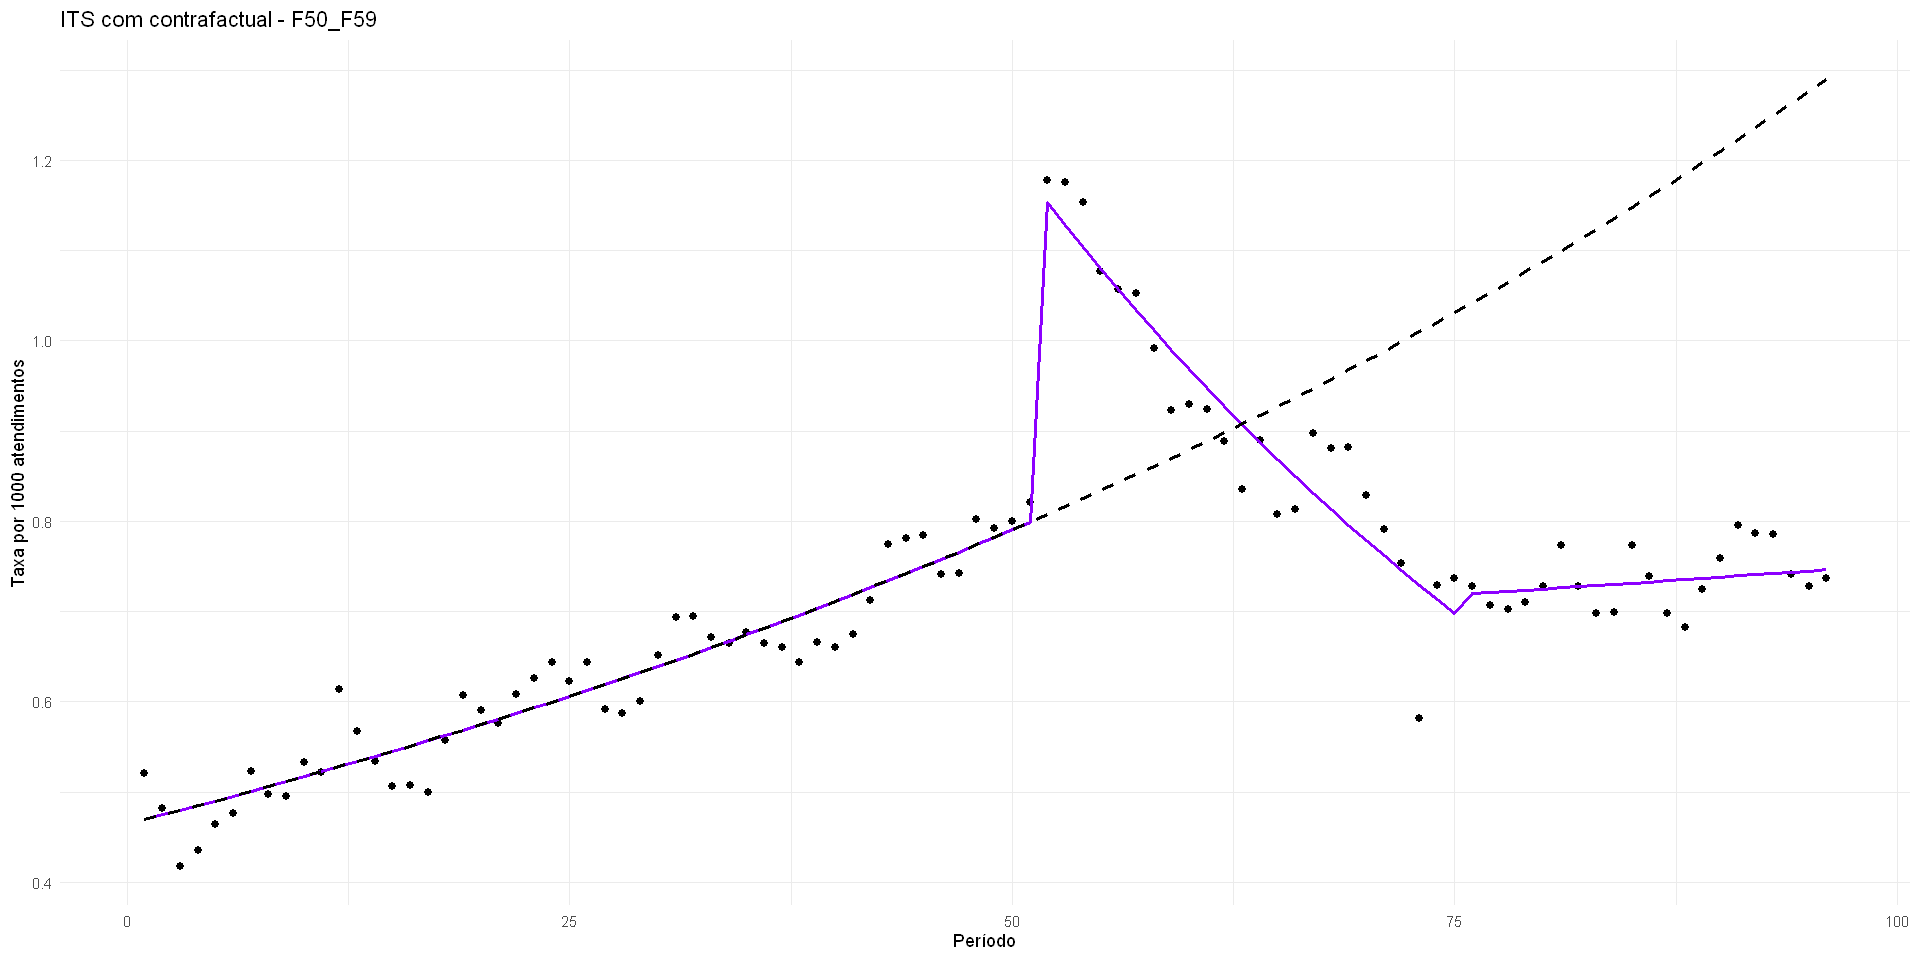

Plotando: F30_F39 


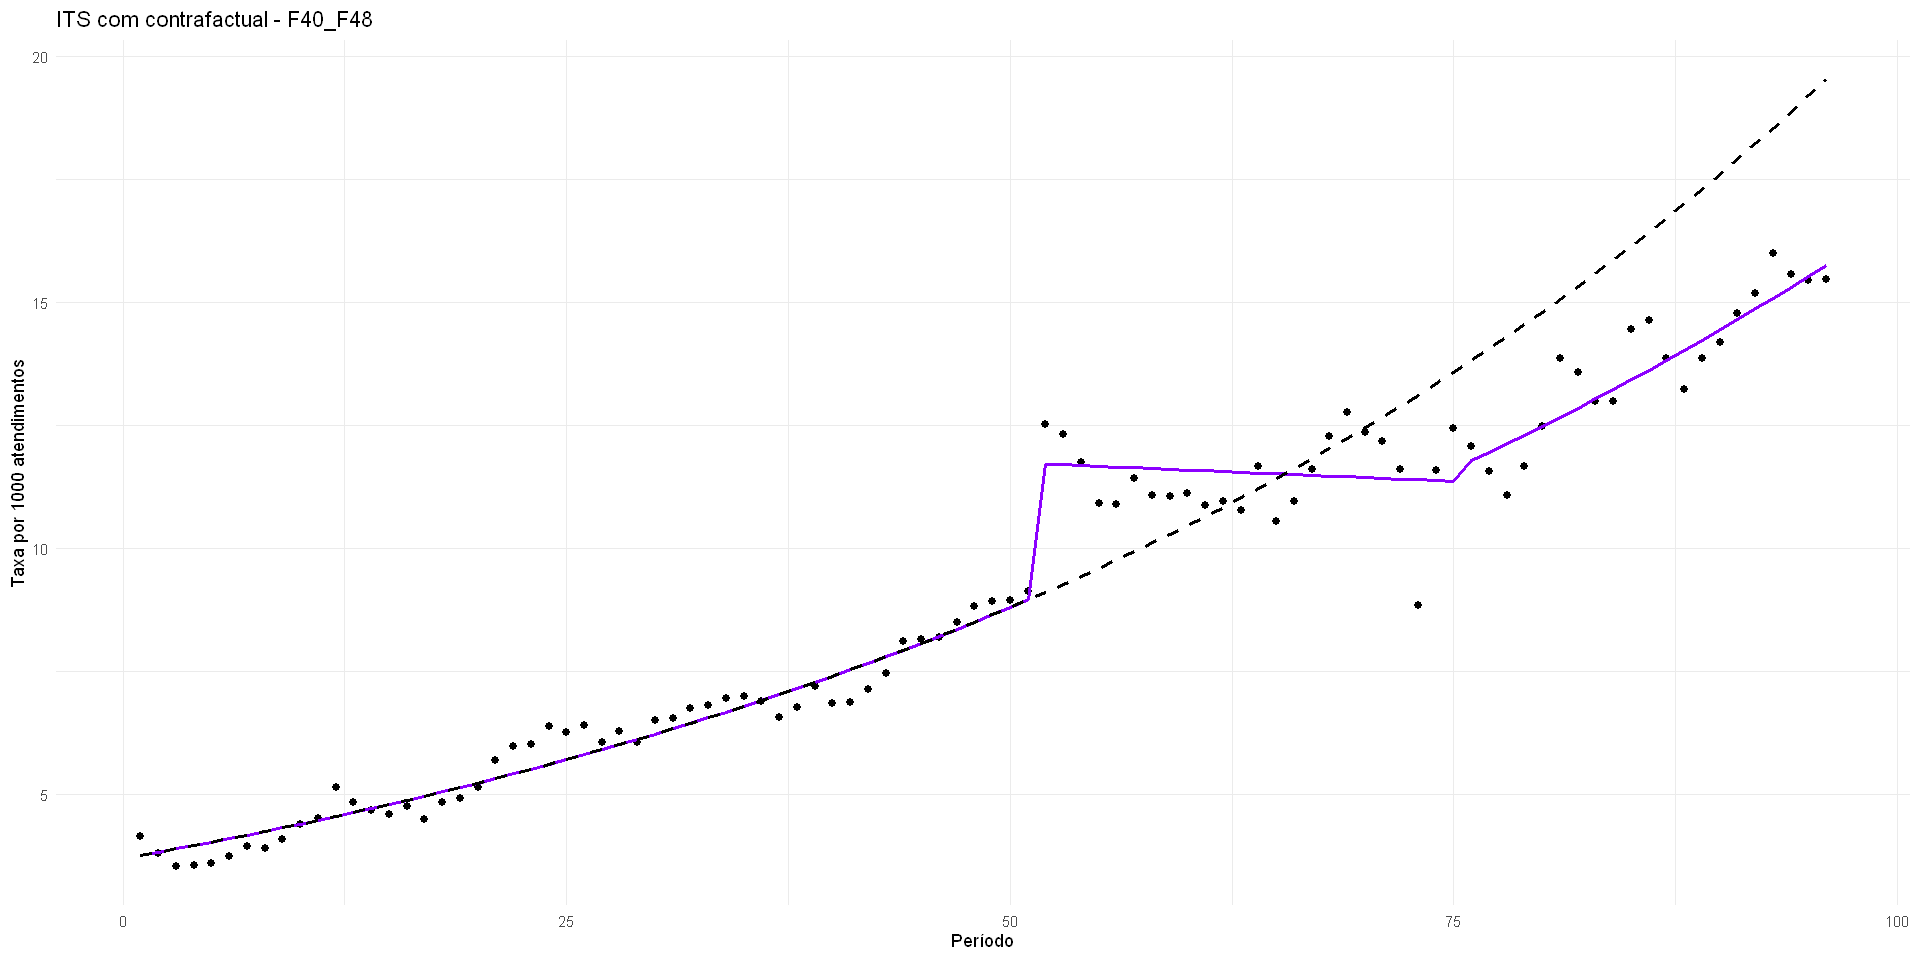

Plotando: F20_F29 


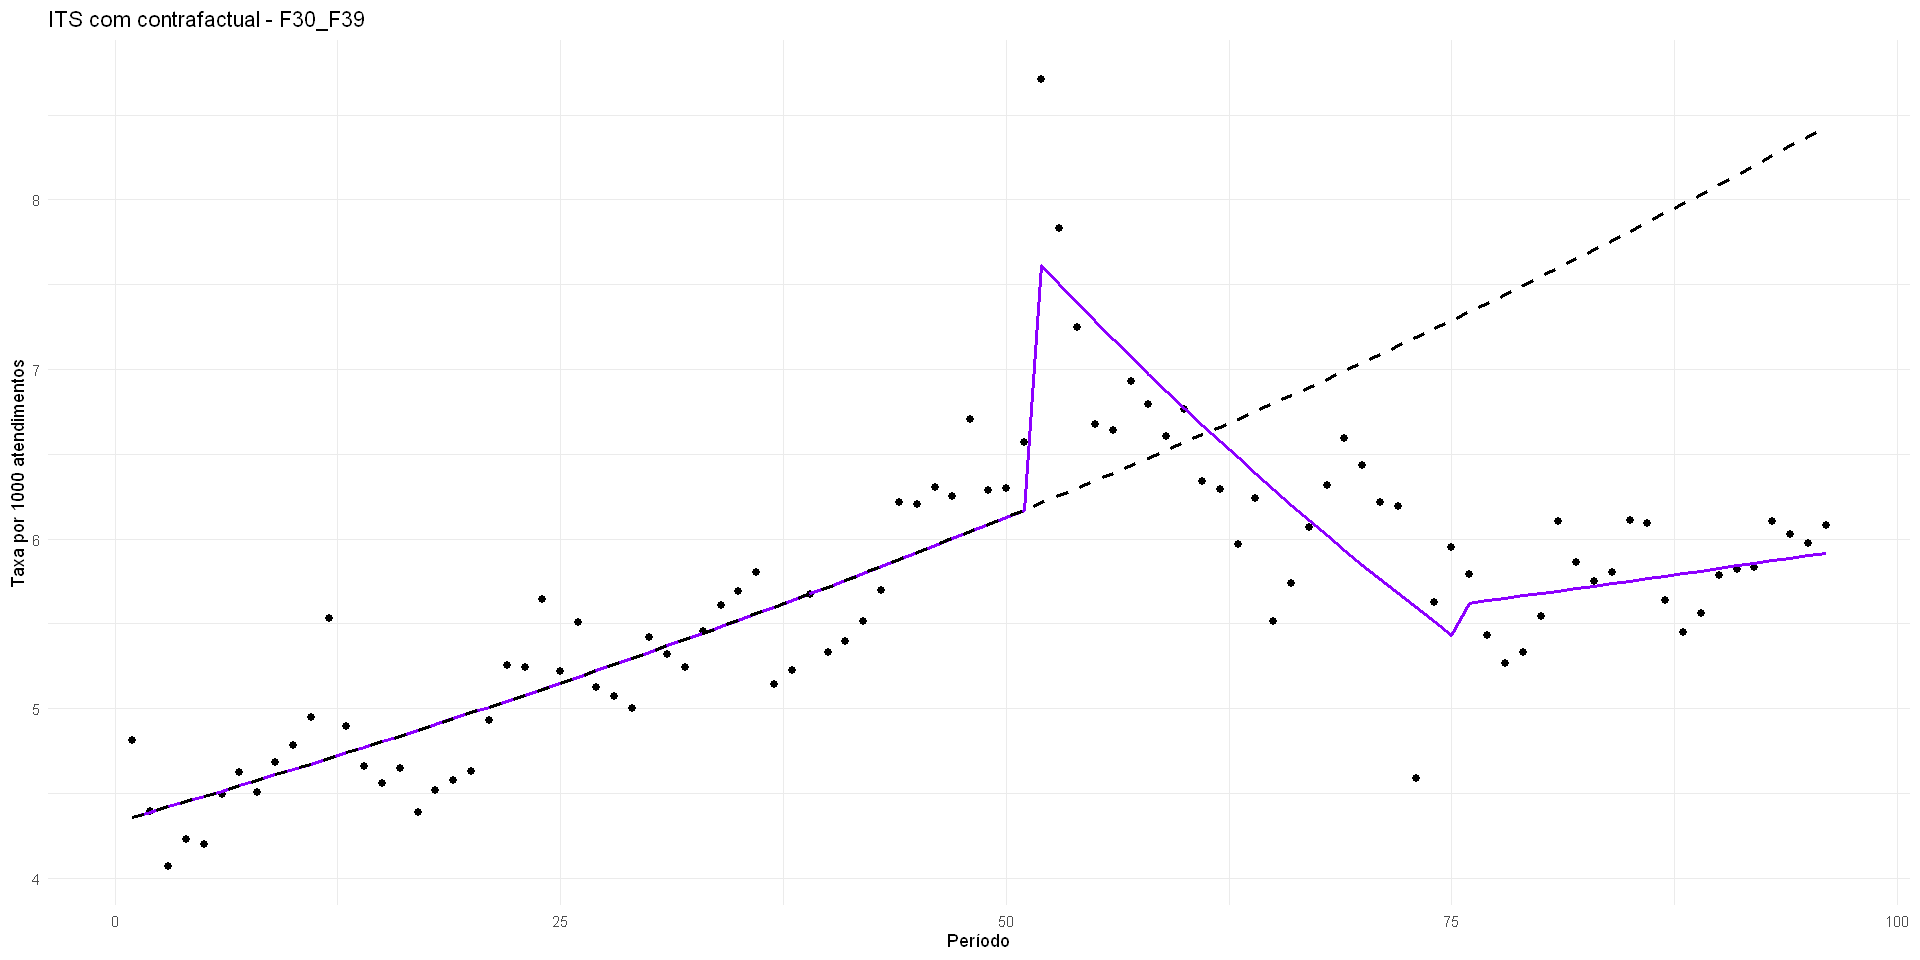

Plotando: F00_F09 


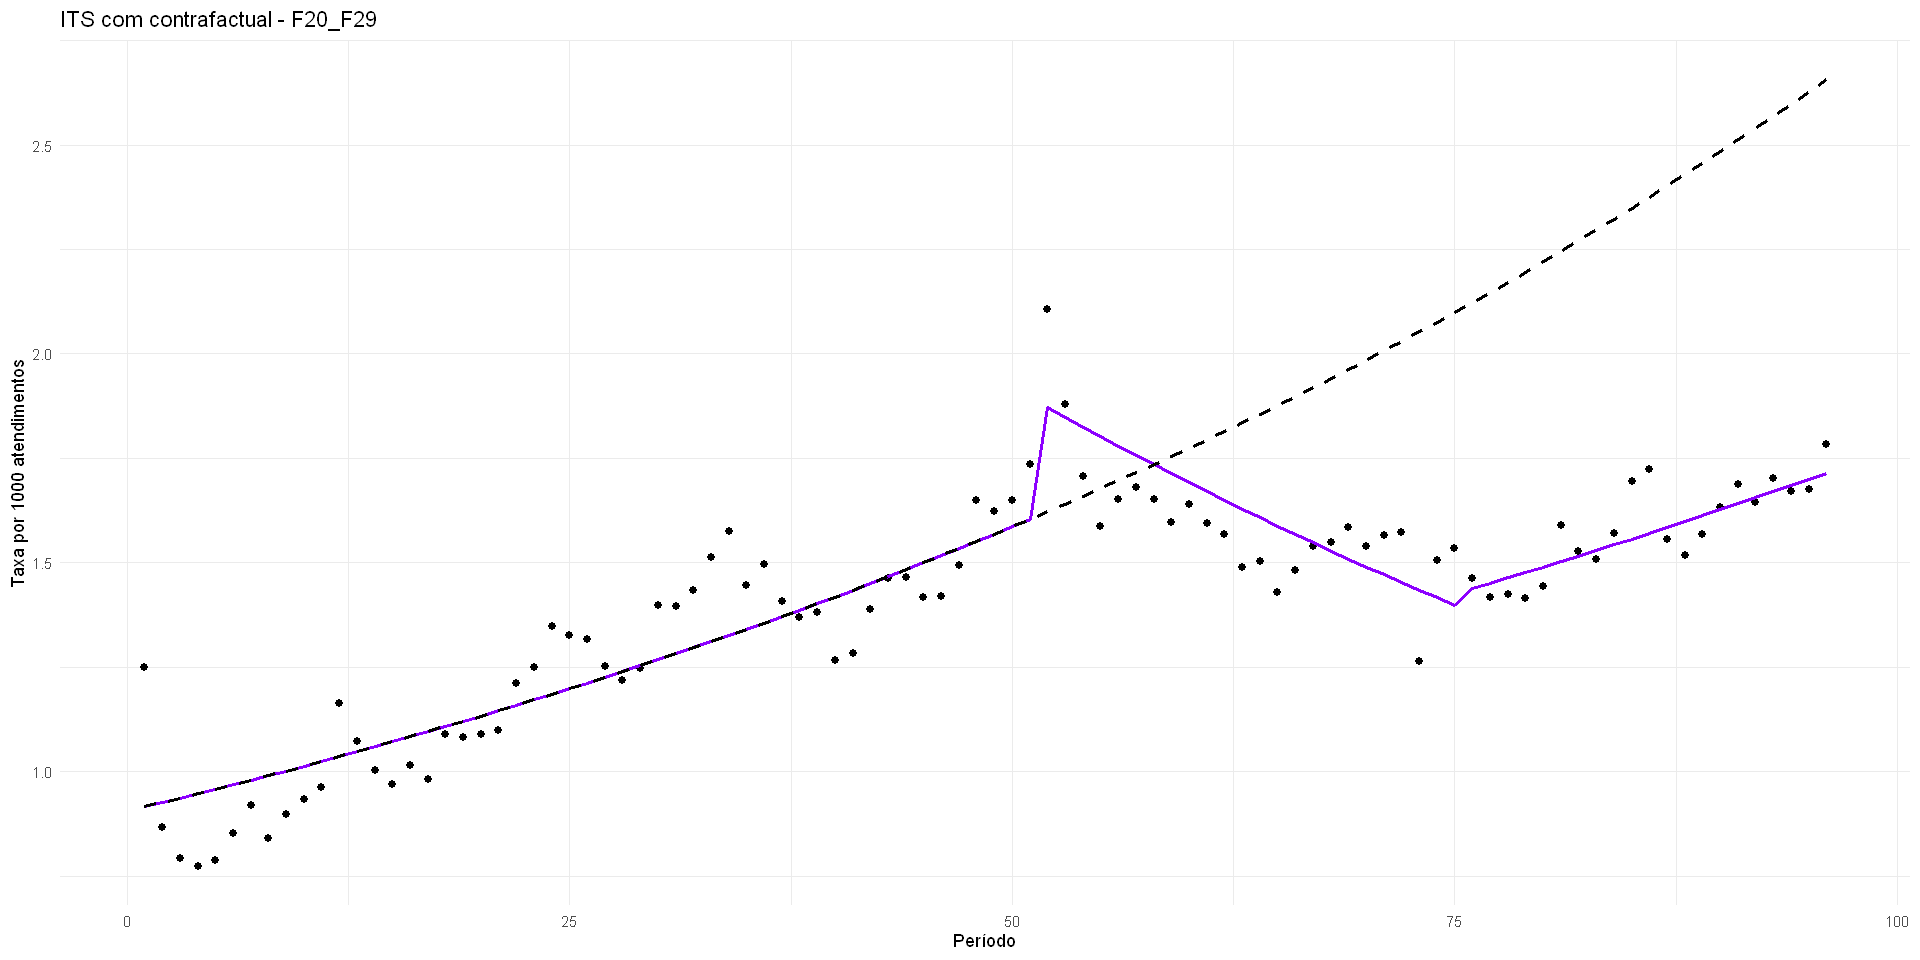

Plotando: Brasil 


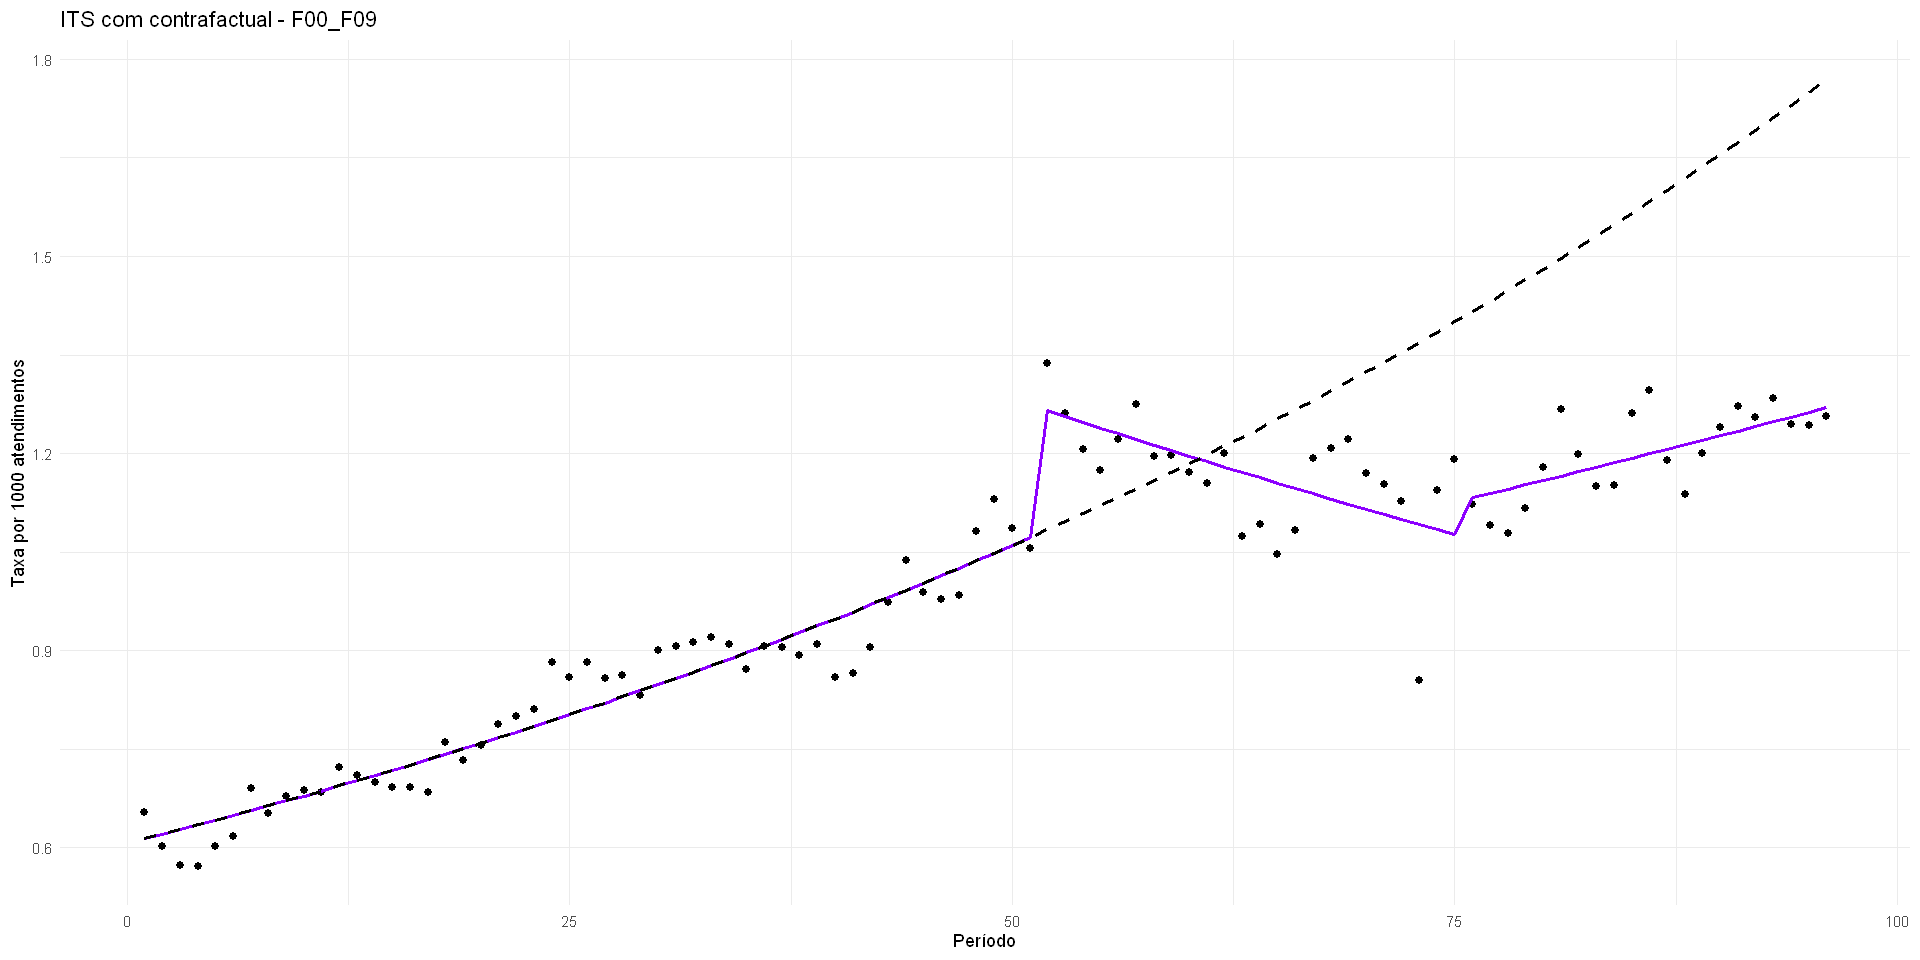

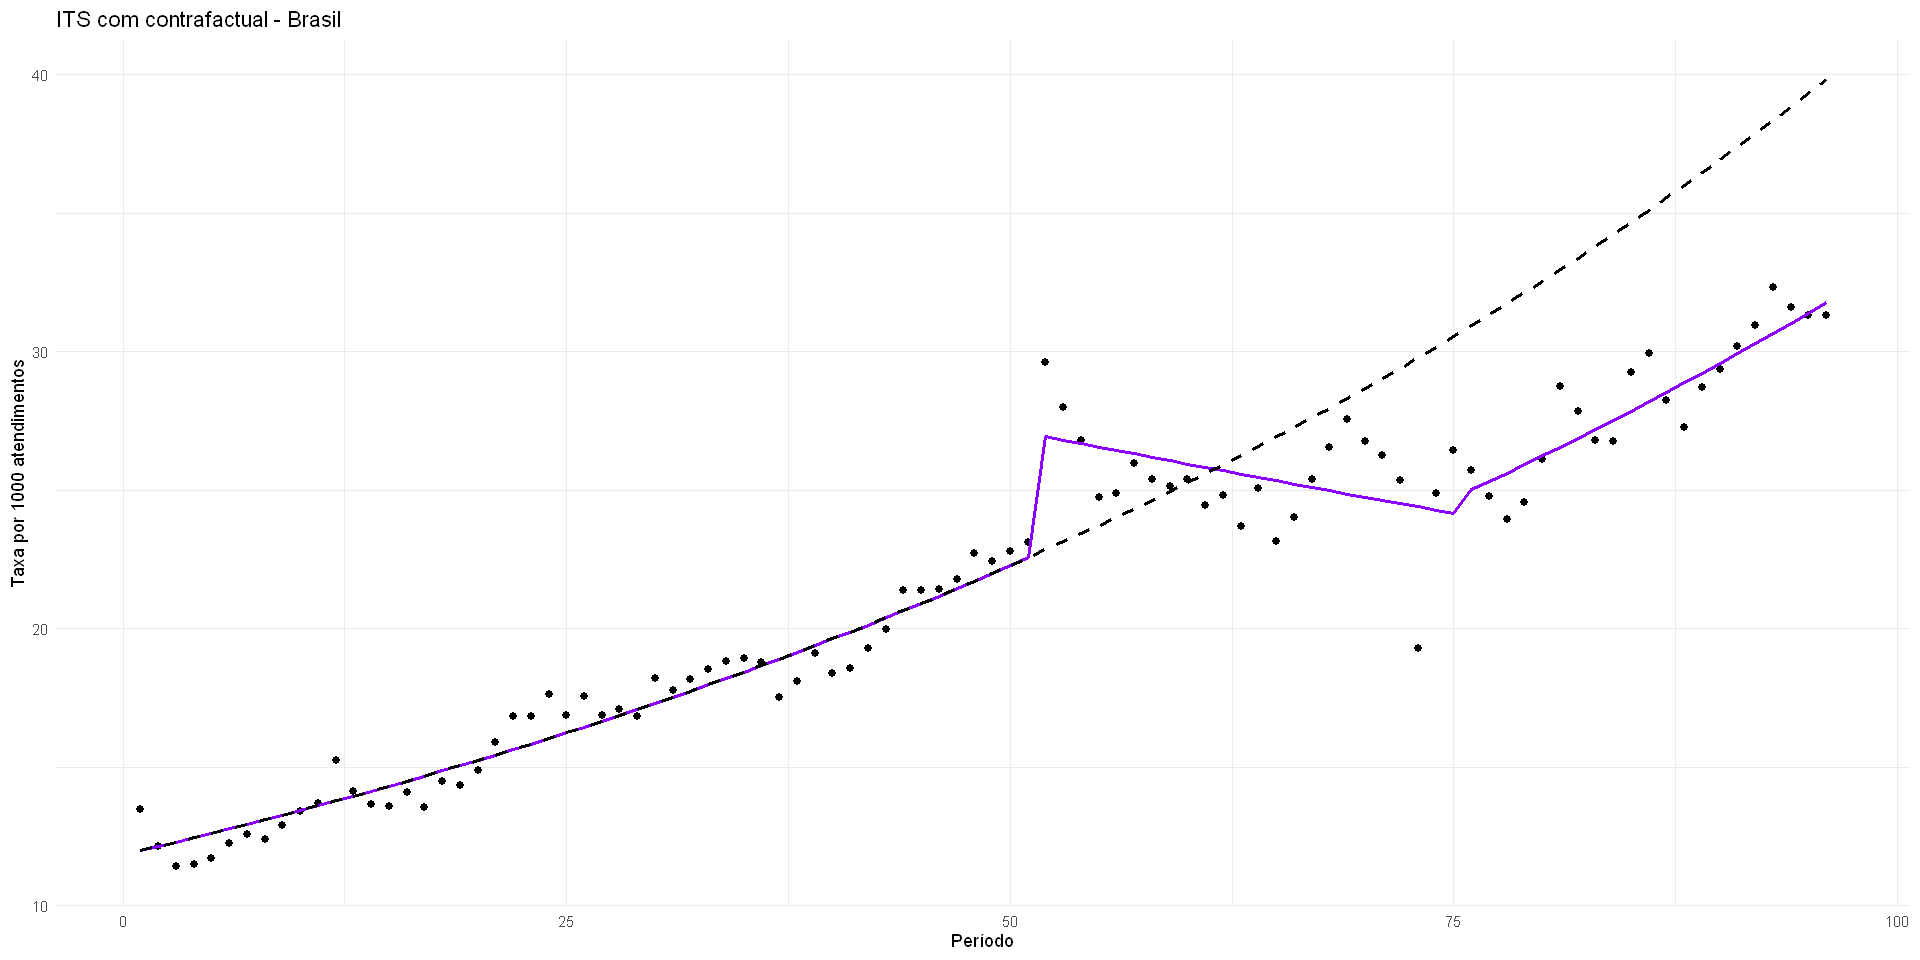

In [25]:
library(ggplot2)
library(dplyr)

for (reg in names(models_list)) {
  cat("Plotando:", reg, "\n")

  model <- models_list[[reg]]
  reg_data <- regression_df %>% filter(regiao == reg)
  reg_data$fitted <- fitted(model)

  coefs <- model$coefficients$fixed

  intercept <- coefs["(Intercept)"]
  b_time <- coefs["periodo"]
  b_pstep <- coefs["Pandemia_Step"]
  b_ptrend <- coefs["Pandemia_Trend"]
  b_poststep <- coefs["PosPandemia_Step"]
  b_posttrend <- coefs["PosPandemia_Trend"]

  reg_data <- reg_data %>%
    mutate(
      fase = case_when(
        PosPandemia_Step == 1 ~ "pos",
        Pandemia_Step == 1 ~ "pandemia",
        TRUE ~ "pre"
      ),
      predicted_segmented = case_when(
        fase == "pre" ~ exp(intercept + b_time * periodo),
        fase == "pandemia" ~ exp(intercept + b_pstep + b_time * periodo + b_ptrend * Pandemia_Trend),
        # fase == "pos" ~ exp(intercept + b_pstep + b_poststep + b_time * periodo +
        #                      b_ptrend * Pandemia_Trend + b_posttrend * PosPandemia_Trend)
        fase == "pos" ~ exp(intercept + b_poststep + b_time * periodo +
          +b_posttrend * PosPandemia_Trend)
      ),
      predicted_counterfactual = exp(intercept + b_time * periodo)
    )

  p <- ggplot(reg_data, aes(x = periodo)) +
    geom_point(aes(y = IR), color = "black", size = 2) +
    geom_line(aes(y = predicted_segmented), color = "#8c00ff", size = 1) +
    geom_line(aes(y = predicted_counterfactual), color = "#000000", linetype = "dashed", size = 1) +
    labs(
      title = paste("ITS com contrafactual -", reg),
      y = "Taxa por 1000 atendimentos",
      x = "Período"
    ) +
    theme_minimal()

  print(p)
}
